# The goal of this notebook is to sort the NCEI storm reports by "outbreak" or synoptic case. Here I'll explore methods to try to do so

In [2]:
### Importing necessary packages
import pandas as pd
from pathlib import Path
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
##Add more as needed

In [3]:
TIMEZONE_MAP = {
    # Eastern
    "EST": "US/Eastern", "EST-5": "US/Eastern", "EDT": "US/Eastern", 
    "E": "US/Eastern", "ET": "US/Eastern",
    
    # Central
    "CST": "US/Central", "CST-6": "US/Central", "CDT": "US/Central", 
    "C": "US/Central", "CT": "US/Central",
    
    # Mountain
    "MST": "US/Mountain", "MST-7": "US/Mountain", "MDT": "US/Mountain", 
    "M": "US/Mountain", "MT": "US/Mountain",
    
    # Pacific
    "PST": "US/Pacific", "PST-8": "US/Pacific", "PDT": "US/Pacific", 
    "P": "US/Pacific", "PT": "US/Pacific",
    
    # Alaska / Hawaii / Atlantic
    "AKST": "US/Alaska", "AST": "US/Alaska", # Note: AST can be Atlantic, but in NCEI context check state
    "HST": "US/Hawaii", "HAWAII": "US/Hawaii",
    "AST-4": "America/Puerto_Rico", "ATLANTIC": "America/Puerto_Rico"
}

def standardize_and_convert_to_utc(df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes the dataframe with 'BEGIN_DT' (Naive) and 'CZ_TIMEZONE',
    converts to UTC taking into account DST transitions.
    """
    
    # 1. Clean the CZ_TIMEZONE column
    # Remove extra spaces and map to IANA strings
    df['clean_tz'] = df['CZ_TIMEZONE'].str.upper().str.strip().map(TIMEZONE_MAP)
    
    # Fill unknown timezones with UTC to prevent crashing (or drop them)
    # Warning: You might want to inspect what falls into 'UTC' later
    df['clean_tz'] = df['clean_tz'].fillna('UTC')

    # 2. Vectorized Conversion
    # We cannot vectorize across mixed timezones, so we group by the timezone.
    utc_chunks = []
    
    # Group by the cleaned timezone string
    for tz_name, group in df.groupby('clean_tz'):
        if tz_name == 'UTC':
            converted = group['BEGIN_DT'].dt.tz_localize('UTC')
        else:
            localized = group['BEGIN_DT'].dt.tz_localize(
                tz_name,
                ambiguous='NaT',      # fall back (clock goes back) -> mark as missing
                nonexistent='shift_forward'  # spring forward -> shift into valid time
            )
            converted = localized.dt.tz_convert('UTC')
        group['BEGIN_DT_UTC'] = converted

        # Assign back to the chunk
        group['BEGIN_DT_UTC'] = converted
        utc_chunks.append(group)

    # 3. Reassemble the dataframe
    df_utc = pd.concat(utc_chunks).sort_index()
    
    # Cleanup helper column
    return df_utc.drop(columns=['clean_tz'])

def build_begin_datetime(df: pd.DataFrame) -> pd.Series:
    """
    Build a reliable datetime from BEGIN_YEARMONTH (YYYYMM), BEGIN_DAY, BEGIN_TIME (HHMM).
    Handles missing/odd times by coercing to NaT if needed.
    """
    # Ensure strings with zero-padding
    yyyymm = df["BEGIN_YEARMONTH"].astype("Int64").astype(str)          # e.g., 201001
    day    = df["BEGIN_DAY"].astype("Int64").astype(str).str.zfill(2)   # e.g., 7 -> "07"

    # BEGIN_TIME can be 0, 30, 930, 2359, or missing. Pad to 4 digits.
    time = (
        df["BEGIN_TIME"]
        .astype("Int64")
        .fillna(0)
        .astype(str)
        .str.zfill(4)
    )

    # Concatenate and parse
    dt_str = yyyymm + day + time
    return pd.to_datetime(dt_str, format="%Y%m%d%H%M", errors="coerce")


In [4]:
# Loading in the data
data_dir = Path("/data1/lepique/stormevents_details/")  
pattern = "StormEvents_details-ftp_v1.0_d*_c*.csv.gz"

storm_types = {"Tornado", "Hail", "Thunderstorm Wind"}
winter_months = {12, 1, 2, 3}


### Keeping only the variables of immediate interest (can modify if needed)
keep_cols = [
    "EVENT_ID", "EPISODE_ID", "EVENT_TYPE",
    "BEGIN_DT",
    "STATE", "WFO",
    "BEGIN_LAT", "BEGIN_LON",
    "MAGNITUDE", "MAGNITUDE_TYPE",
]


# --- Find all yearly files ---
files = sorted(data_dir.glob(pattern))
print(f"Found {len(files)} files")

dfs = []

for fp in files:
    # Extract the year from filename (the 'dYYYY' part)
    m = re.search(r"_d(\d{4})_", fp.name)
    year = int(m.group(1)) if m else None

    print(f"Reading {fp.name} (year={year})")

    df = pd.read_csv(fp, compression="gzip", low_memory=False)

    # Ensure datetime is datetime (works even if already parsed)
    df["BEGIN_DT"] = build_begin_datetime(df)
    df = df.dropna(subset=["BEGIN_DT"])


    # Drop rows with missing begin time (rare but safer for dt.month)
    df = df.dropna(subset=["BEGIN_DATE_TIME"])

    # DJFM filter
    df = df[df["BEGIN_DT"].dt.month.isin(winter_months)]
    
    # December-year winter label
    dt = df["BEGIN_DT"]
    df["WINTER_SEASON"] = dt.dt.year - dt.dt.month.isin(winter_months).astype(int)

    

    # Storm-type filter
    df = df[df["EVENT_TYPE"].isin(storm_types)]

    # Keep only the columns we care about (plus WINTER_SEASON)
#    cols = ["WINTER_SEASON"] + keep_cols
#    df = df[cols].copy()

    # Optional: also store source year (from filename) to help debugging
    df["SOURCE_FILE_YEAR"] = year

    dfs.append(df)

# --- Concatenate all years ---
df_winter_scs = pd.concat(dfs, ignore_index=True)
df_winter_scs = df_winter_scs[df_winter_scs["WINTER_SEASON"] >= 1950]  ## Eliminating JFM 1950 because we don't have full winter season


# Adding a UTC Time column
df_winter_scs = standardize_and_convert_to_utc(df_winter_scs)

print("Done.")
print(df_winter_scs.shape)
print(df_winter_scs["EVENT_TYPE"].value_counts())
print(df_winter_scs["WINTER_SEASON"].min(), df_winter_scs["WINTER_SEASON"].max())

Found 76 files
Reading StormEvents_details-ftp_v1.0_d1950_c20250520.csv.gz (year=1950)
Reading StormEvents_details-ftp_v1.0_d1951_c20250520.csv.gz (year=1951)
Reading StormEvents_details-ftp_v1.0_d1952_c20250520.csv.gz (year=1952)
Reading StormEvents_details-ftp_v1.0_d1953_c20250520.csv.gz (year=1953)
Reading StormEvents_details-ftp_v1.0_d1954_c20250520.csv.gz (year=1954)
Reading StormEvents_details-ftp_v1.0_d1955_c20250520.csv.gz (year=1955)
Reading StormEvents_details-ftp_v1.0_d1956_c20250520.csv.gz (year=1956)
Reading StormEvents_details-ftp_v1.0_d1957_c20250520.csv.gz (year=1957)
Reading StormEvents_details-ftp_v1.0_d1958_c20250520.csv.gz (year=1958)
Reading StormEvents_details-ftp_v1.0_d1959_c20250520.csv.gz (year=1959)
Reading StormEvents_details-ftp_v1.0_d1960_c20250520.csv.gz (year=1960)
Reading StormEvents_details-ftp_v1.0_d1961_c20250520.csv.gz (year=1961)
Reading StormEvents_details-ftp_v1.0_d1962_c20250520.csv.gz (year=1962)
Reading StormEvents_details-ftp_v1.0_d1963_c20250

In [5]:
subset = df_winter_scs[df_winter_scs["WINTER_SEASON"] >= 1995]

In [6]:
def create_synoptic_cases(df, gap_threshold_hours=12):
    """
    Groups NCEI Episodes into Synoptic Cases based on a time gap threshold.
    
    Args:
        df: The dataframe of storm reports.
        gap_threshold_hours: Hours of 'silence' required to start a new case.
                             12 hours is standard for synoptic separation.
                             6 hours is strict. 
                             72 hours is common for Reinsurance 'Event' clauses.
    """
    
    # 1. Isolate unique Episodes first
    # We group by EPISODE_ID to find the earliest start and latest start of that specific episode
    # (Using BEGIN_DT for both to keep it simple, or create END_DT if available)
    episodes = df.groupby('EPISODE_ID', as_index=False).agg({
        'BEGIN_DT_UTC': 'min', 
        'BEGIN_LAT': 'mean',
        'BEGIN_LON': 'mean'
    }).sort_values('BEGIN_DT_UTC')

    threshold = pd.Timedelta(hours=gap_threshold_hours)

    
     # 2. Walk forward in time, comparing to the *start* of the current case
    case_ids = []
    current_case_id = 0
    current_case_start = None

    for t in episodes['BEGIN_DT_UTC']:
        if current_case_start is None or (t - current_case_start) > threshold:
            # Start a new synoptic case
            current_case_id += 1
            current_case_start = t
        case_ids.append(current_case_id)

    episodes['SYNOPTIC_CASE_ID'] = case_ids

    # 3. Merge back to the full dataframe
    return df.merge(
        episodes[['EPISODE_ID', 'SYNOPTIC_CASE_ID']],
        on='EPISODE_ID',
        how='left',
    )


In [7]:
# --- Run the function ---
# A 12-hour gap is a solid meteorological definition for separating synoptic waves.
# If reports stop for 12 hours, the next report is likely a new system.
subset = create_synoptic_cases(subset, gap_threshold_hours=12)

print(f"Total Unique Episodes: {subset['EPISODE_ID'].nunique()}")
print(f"Total Synoptic Cases: {subset['SYNOPTIC_CASE_ID'].nunique()}")

Total Unique Episodes: 22051
Total Synoptic Cases: 2128


In [8]:
print(len(subset))
print(subset['EVENT_ID'].nunique())

85214
85214


So each event ID is unique across time, so I can sort by event ID

In [9]:
def create_case_stats(df):
    """
    Create a new dataframe of synoptic case statistics to analyze
    """
    
    case_stats = df.groupby('SYNOPTIC_CASE_ID').agg({
    'WINTER_SEASON': 'first',             # The season this case belongs to
    'BEGIN_DT': ['min', 'max'],           # Start/End times
    'EVENT_TYPE': 'count',                # Total reports
    'BEGIN_LAT': 'mean',                  # Centroid Lat
    'BEGIN_LON': 'mean',                  # Centroid Lon
    'EVENT_ID': 'nunique'                 # Double check unique events
})
    
    case_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in case_stats.columns.values]
    case_stats = case_stats.rename(columns={'WINTER_SEASON_first': 'Season', 'EVENT_TYPE_count': 'Report_Count'})
    
    # Calculate Duration (in Hours)
    case_stats['Duration_Hrs'] = (case_stats['BEGIN_DT_max'] - case_stats['BEGIN_DT_min']).dt.total_seconds() / 3600

    print(f"Total Synoptic Cases: {len(case_stats)}")
    
    return case_stats

In [10]:
case_stats = create_case_stats(subset)

Total Synoptic Cases: 2128


In [11]:
case_stats['Duration_Hrs'].max()

np.float64(680.0)

In [15]:
longest_case_id = case_stats['Duration_Hrs'].idxmax()
longest_case_id

np.int64(255)

In [16]:
## Helper function to get events for a given case ID:
def events_for_case(df, case_id):
    """
    Return all events (or rows) for a single case ID, sorted by time.
    """
    return (
        df[df['SYNOPTIC_CASE_ID'] == case_id]
        .sort_values('BEGIN_DT_UTC')
        .copy()
    )

In [37]:
def plot_case(df, case_id, title_prefix="Synoptic case"):
    """Full-US cartopy map for one SYNOPTIC_CASE_ID using the main dataframe.

    Blue = Thunderstorm Wind, Green = Hail, Red = Tornado.
    """
    # Filter to this case
    case_df = df[df['SYNOPTIC_CASE_ID'] == case_id].copy()
    if case_df.empty:
        print(f"No rows found for SYNOPTIC_CASE_ID={case_id}")
        return

    # Normalize event types
    et = case_df['EVENT_TYPE'].str.upper().fillna("OTHER")
    is_tor  = et.str.contains("TORNADO")
    is_hail = et.str.contains("HAIL")
    is_wind = et.str.contains("THUNDERSTORM WIND") | et.str.contains("TSTM WIND")

    # Map projection
    proj = ccrs.LambertConformal(
        central_longitude=-96, central_latitude=39,
        standard_parallels=(33, 45),
    )

    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=proj)

    # CONUS extent
    ax.set_extent([-130, -65, 23, 50], crs=ccrs.PlateCarree())

    # Base map
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.6)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.4)

    transform = ccrs.PlateCarree()

    # Wind – blue
    ax.scatter(
        case_df.loc[is_wind, 'BEGIN_LON'],
        case_df.loc[is_wind, 'BEGIN_LAT'],
        s=8, c='blue', alpha=0.7, transform=transform, label='Wind',
    )

    # Hail – green
    ax.scatter(
        case_df.loc[is_hail, 'BEGIN_LON'],
        case_df.loc[is_hail, 'BEGIN_LAT'],
        s=8, c='green', alpha=0.7, transform=transform, label='Hail',
    )

    # Tornado – red
    ax.scatter(
        case_df.loc[is_tor, 'BEGIN_LON'],
        case_df.loc[is_tor, 'BEGIN_LAT'],
        s=12, c='red', alpha=0.8, transform=transform, label='Tornado',
    )

    ax.legend(loc='upper right', fontsize=9, framealpha=0.8)

    # Title with start/end and duration
    title = f"{title_prefix} {case_id}"
    time_col = 'BEGIN_DT_UTC' if 'BEGIN_DT_UTC' in case_df.columns else 'BEGIN_DT'
    if time_col in case_df.columns:
        tmin = case_df[time_col].min()
        tmax = case_df[time_col].max()
        if pd.notna(tmin) and pd.notna(tmax):
            # Format nicely, keeping UTC label if tz-aware UTC
            if hasattr(tmin, 'tzinfo') and tmin.tzinfo is not None:
                tmin_str = tmin.strftime('%Y-%m-%d %H:%M UTC')
                tmax_str = tmax.strftime('%Y-%m-%d %H:%M UTC')
            else:
                tmin_str = tmin.strftime('%Y-%m-%d %H:%M')
                tmax_str = tmax.strftime('%Y-%m-%d %H:%M')
            dur = (tmax - tmin).total_seconds() / 3600
            title += f"\n{tmin_str} to {tmax_str}  (Δ={dur:.1f} h)"

    ax.set_title(title, fontsize=13)
    plt.tight_layout()
    plt.show()

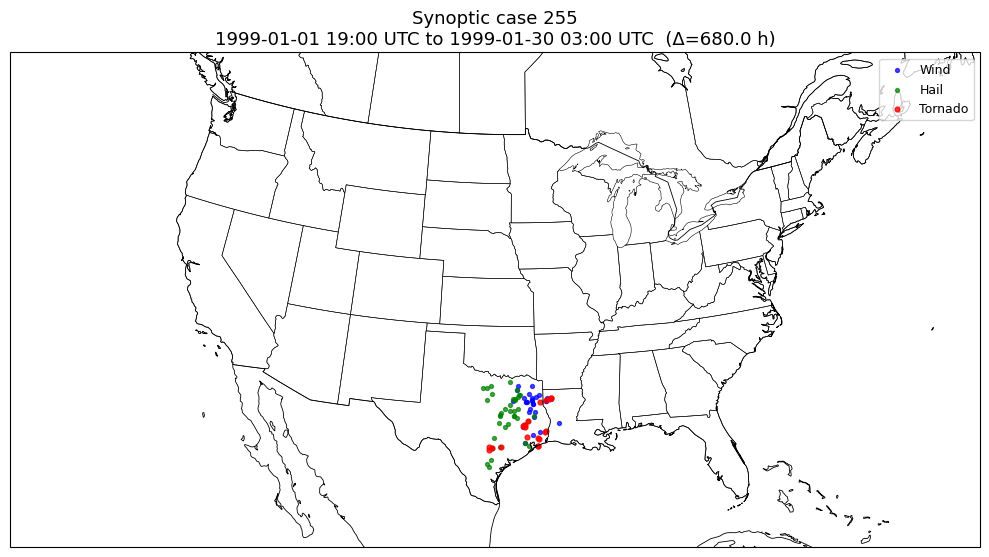

In [38]:
# Longest-duration case
longest_case_id = case_stats['Duration_Hrs'].idxmax()
plot_case(subset, longest_case_id)

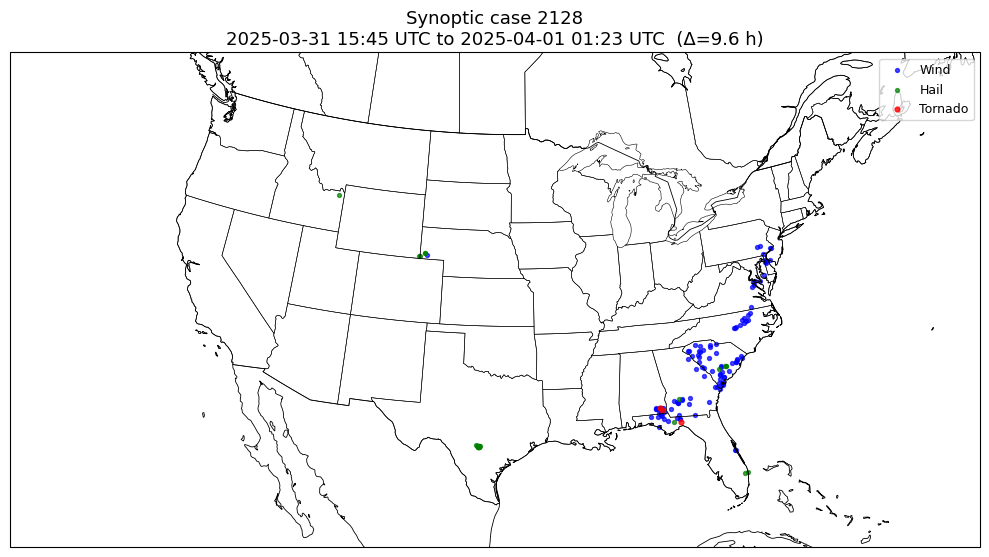

In [46]:
plot_case(subset, case_id=2128)